In [1]:
import scanpy as sc
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


In [56]:
latent = sc.read('./data/11_latent_moe.h5ad')
latent1 = sc.read('./data/11_latent_moe.h5ad')
latent2 = sc.read('./data/11_latent_moe.h5ad')
latent3 = sc.read('./data/11_latent_moe.h5ad')
adata = sc.read('./data/09_tcr_annotation_A_B_with_gender_data.h5ad')

In [57]:
sc.pp.neighbors(latent1, n_neighbors=5, method='gauss', knn=False)
sc.pp.neighbors(latent, n_neighbors=5, method='gauss', knn=False)
#sc.pp.neighbors(adata, n_neighbors=5, method='gauss', knn=False)

In [58]:
sc.tl.leiden(latent1, resolution=1)
sc.tl.leiden(latent, resolution=0.05)

In [59]:
latent2.obs['leiden'] = latent1.obs['leiden']
latent3.obs['leiden'] = latent1.obs['leiden']

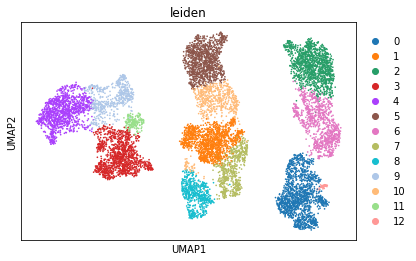

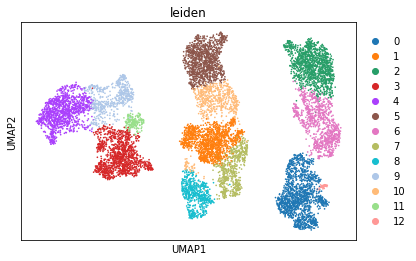

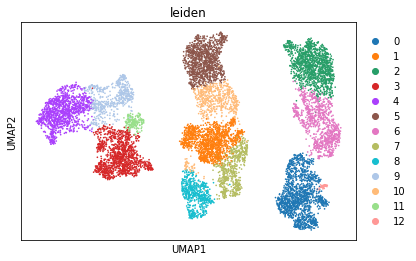

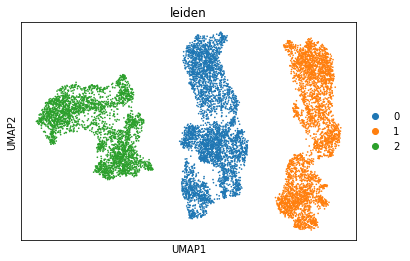

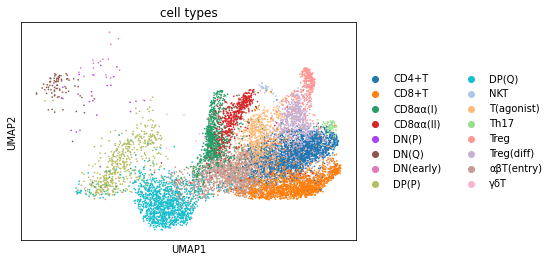

In [83]:
sc.pl.umap(latent1, color = "leiden")
sc.pl.umap(latent2, color = "leiden")
sc.pl.umap(latent3, color = "leiden")
sc.pl.umap(latent, color = "leiden")
sc.pl.umap(adata, color = "cell types")

In [84]:
latent1.uns['iroot'] = np.flatnonzero(latent1.obs['leiden']  == '2')[0]
latent2.uns['iroot'] = np.flatnonzero(latent2.obs['leiden']  == '5')[0]
latent3.uns['iroot'] = np.flatnonzero(latent3.obs['leiden']  == '3')[0]
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell types']  == 'CD8+T')[0]

In [62]:
sc.pp.neighbors(latent1, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent1)
sc.tl.dpt(latent1, n_branchings=1, n_dcs=10)

sc.pp.neighbors(latent2, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent2)
sc.tl.dpt(latent2, n_branchings=1, n_dcs=10)

sc.pp.neighbors(latent3, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent3)
sc.tl.dpt(latent3, n_branchings=1, n_dcs=10)

In [85]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=1, n_dcs=10)

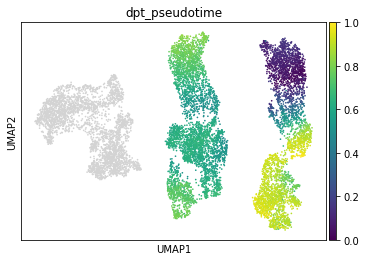

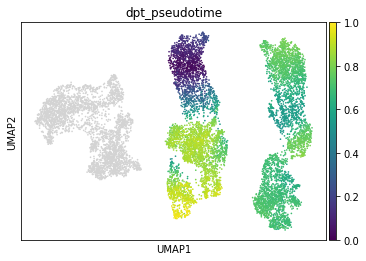

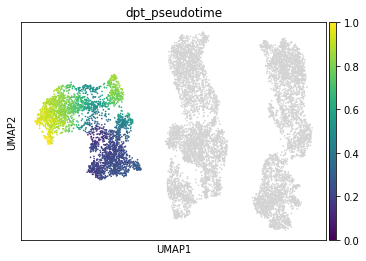

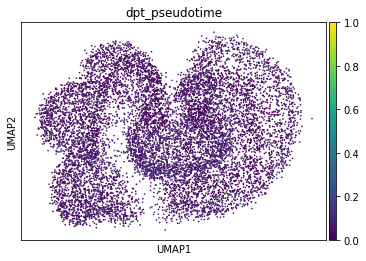

In [86]:
sc.pp.neighbors(latent1, use_rep='X')
sc.tl.umap(latent1)
sc.pl.umap(latent1, color='dpt_pseudotime')

sc.pp.neighbors(latent2, use_rep='X')
sc.tl.umap(latent2)
sc.pl.umap(latent2, color='dpt_pseudotime')

sc.pp.neighbors(latent3, use_rep='X')
sc.tl.umap(latent3)
sc.pl.umap(latent3, color='dpt_pseudotime')

sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color='dpt_pseudotime')

In [64]:
latent1.obs['leiden2'] = latent.obs['leiden']
latent2.obs['leiden2'] = latent.obs['leiden']
latent3.obs['leiden2'] = latent.obs['leiden']

In [72]:
latent1.obs['dpt_pseudotime'][latent1.obs['leiden2']=='1']
latent2.obs['dpt_pseudotime'][latent2.obs['leiden2']=='0']
latent3.obs['dpt_pseudotime'][latent3.obs['leiden2']=='2']

3118

## Results with f1_score and liblinear solver (similar results using newton-cg though)

In [81]:
k = 10
kf = KFold(n_splits=k) 
model = LogisticRegression(solver = 'liblinear')
def results_cross_validation(X, y, score):
    X = X.reshape(-1,1)
    acc_score = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        if score == 'accuracy_score':
            acc = accuracy_score(y_true = y_test, y_pred = pred_values)
        if score == 'f1_score':
            acc = f1_score(y_true = y_test, y_pred = pred_values, average='weighted')
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/k
    return(acc_score, avg_acc_score)

In [87]:
le = LabelEncoder()
X = latent1.obs['dpt_pseudotime'][latent1.obs['leiden2']=='1'].to_numpy()
y = latent1.obs['cell types'][latent1.obs['leiden2']=='1'].to_numpy()
le.fit(y)
y = le.transform(y)
results = results_cross_validation(X,y, score = 'f1_score')
print("Results for the latent space, blob1:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


X = latent2.obs['dpt_pseudotime'][latent2.obs['leiden2']=='0'].to_numpy()
y = latent2.obs['cell types'][latent2.obs['leiden2']=='0'].to_numpy()
le.fit(y)
y = le.transform(y)
results = results_cross_validation(X,y, score = 'f1_score')
print("Results for the latent space, blob2:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


X = latent3.obs['dpt_pseudotime'][latent3.obs['leiden2']=='2'].to_numpy()
y = latent3.obs['cell types'][latent3.obs['leiden2']=='2'].to_numpy()
le.fit(y)
y = le.transform(y)
results = results_cross_validation(X,y, score = 'f1_score')
print("Results for the latent space, blob3:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


X = adata.obs['dpt_pseudotime'].to_numpy()
y = adata.obs['cell types'].to_numpy()
le.fit(y)
y = le.transform(y)
results2 = results_cross_validation(X,y, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results2[0]))
print('Avg accuracy : {}'.format(results2[1]))


Results for the latent space, blob1:
 
accuracy of each fold - [0.16764114451440998, 0.1636379445265629, 0.1790775544810553, 0.1408257632975099, 0.22005049602484253, 0.1689867175835148, 0.05433011524217735, 0.012037418741081336, 0.025052193271371353, 0.017752336787189335]
Avg accuracy : 0.1149391684469715
Results for the latent space, blob2:
 
accuracy of each fold - [0.18907757158774194, 0.20471668524041664, 0.21068686887356833, 0.2749357803022556, 0.19758604312187655, 0.13551915080557003, 0.05368379269086263, 0.013141573129622202, 0.01566114855917933, 0.020852122234899986]
Avg accuracy : 0.13158607365459934
Results for the latent space, blob3:
 
accuracy of each fold - [0.1492923330794618, 0.07020430549842314, 0.10939737081869062, 0.1368945868945869, 0.09542690985989956, 0.059608903916596234, 0.022033730158730152, 0.018028846153846152, 0.04171923969229516, 0.024676587153219173]
Avg accuracy : 0.07272828132257489
 
Results for the adata space:
 
accuracy of each fold - [0.160454830369

In [88]:
latent1.uns['iroot'] = np.flatnonzero(latent1.obs['leiden']  == '0')[0]
latent2.uns['iroot'] = np.flatnonzero(latent2.obs['leiden']  == '8')[0]
latent3.uns['iroot'] = np.flatnonzero(latent3.obs['leiden']  == '4')[0]
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell types']  == 'Th17')[0]

In [89]:
sc.pp.neighbors(latent1, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent1)
sc.tl.dpt(latent1, n_branchings=1, n_dcs=10)

sc.pp.neighbors(latent2, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent2)
sc.tl.dpt(latent2, n_branchings=1, n_dcs=10)

sc.pp.neighbors(latent3, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(latent3)
sc.tl.dpt(latent3, n_branchings=1, n_dcs=10)

In [90]:
sc.pp.neighbors(adata, n_neighbors=20, use_rep='X', method='gauss')
sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=1, n_dcs=10)

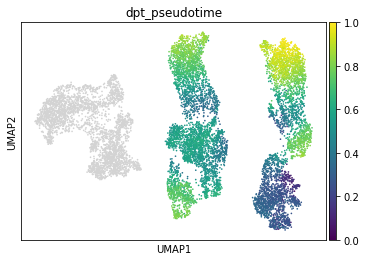

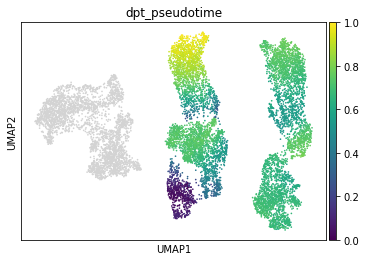

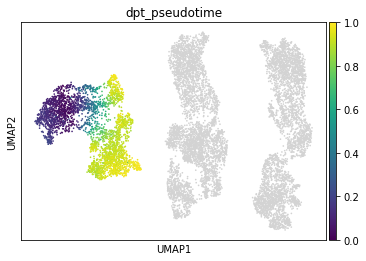

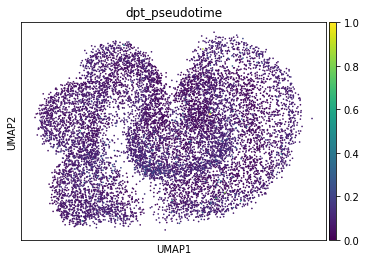

In [91]:
sc.pp.neighbors(latent1, use_rep='X')
sc.tl.umap(latent1)
sc.pl.umap(latent1, color='dpt_pseudotime')

sc.pp.neighbors(latent2, use_rep='X')
sc.tl.umap(latent2)
sc.pl.umap(latent2, color='dpt_pseudotime')

sc.pp.neighbors(latent3, use_rep='X')
sc.tl.umap(latent3)
sc.pl.umap(latent3, color='dpt_pseudotime')

sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.umap(adata, color='dpt_pseudotime')

In [92]:
latent1.obs['leiden2'] = latent.obs['leiden']
latent2.obs['leiden2'] = latent.obs['leiden']
latent3.obs['leiden2'] = latent.obs['leiden']

## Results with f1_score and liblinear solver (similar results using newton-cg though)

In [93]:
k = 10
kf = KFold(n_splits=k) 
model = LogisticRegression(solver = 'liblinear')
def results_cross_validation(X, y, score):
    X = X.reshape(-1,1)
    acc_score = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)

        if score == 'accuracy_score':
            acc = accuracy_score(y_true = y_test, y_pred = pred_values)
        if score == 'f1_score':
            acc = f1_score(y_true = y_test, y_pred = pred_values, average='weighted')
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/k
    return(acc_score, avg_acc_score)

In [94]:
le = LabelEncoder()
X = latent1.obs['dpt_pseudotime'][latent1.obs['leiden2']=='1'].to_numpy()
y = latent1.obs['cell types'][latent1.obs['leiden2']=='1'].to_numpy()
le.fit(y)
y = le.transform(y)
results = results_cross_validation(X,y, score = 'f1_score')
print("Results for the latent space, blob1:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


X = latent2.obs['dpt_pseudotime'][latent2.obs['leiden2']=='0'].to_numpy()
y = latent2.obs['cell types'][latent2.obs['leiden2']=='0'].to_numpy()
le.fit(y)
y = le.transform(y)
results = results_cross_validation(X,y, score = 'f1_score')
print("Results for the latent space, blob2:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


X = latent3.obs['dpt_pseudotime'][latent3.obs['leiden2']=='2'].to_numpy()
y = latent3.obs['cell types'][latent3.obs['leiden2']=='2'].to_numpy()
le.fit(y)
y = le.transform(y)
results = results_cross_validation(X,y, score = 'f1_score')
print("Results for the latent space, blob3:")
print(" ")
print('accuracy of each fold - {}'.format(results[0]))
print('Avg accuracy : {}'.format(results[1]))


X = adata.obs['dpt_pseudotime'].to_numpy()
y = adata.obs['cell types'].to_numpy()
le.fit(y)
y = le.transform(y)
results2 = results_cross_validation(X,y, score = 'f1_score')
print(" ")
print("Results for the adata space:")
print(" ")
print('accuracy of each fold - {}'.format(results2[0]))
print('Avg accuracy : {}'.format(results2[1]))


Results for the latent space, blob1:
 
accuracy of each fold - [0.11091173998453187, 0.10292328284866635, 0.10627330403294803, 0.21464188068232354, 0.08216545567913579, 0.09158550072103479, 0.036590942738234274, 0.08009082234619751, 0.07702702702702703, 0.0709484908637451]
Avg accuracy : 0.09731584469238443
Results for the latent space, blob2:
 
accuracy of each fold - [0.24809890546343205, 0.21334493503177387, 0.25651422725412515, 0.3886085133134325, 0.3549661371596108, 0.2966662668707911, 0.18936410997071124, 0.048594669908936086, 0.06944502705894748, 0.05373245992178031]
Avg accuracy : 0.21193352519535408
Results for the latent space, blob3:
 
accuracy of each fold - [0.2195679754273504, 0.11930052009886427, 0.21648614795166518, 0.27898479229748585, 0.2247849632659227, 0.12960795948732848, 0.05043552717374642, 0.00400130654907725, 0.010008167822913328, 0.010765598925475192]
Avg accuracy : 0.1263942958999829
 
Results for the adata space:
 
accuracy of each fold - [0.1856783622921373